<a href="https://colab.research.google.com/github/yael-katsman/Tech_career_roadmap/blob/main/model_and_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading junior, senior and expert dfs

In [ ]:
pip install gdown==4.6.0


In [20]:
import pandas as pd
import pickle
import gdown
### junior:
!gdown --id 1IBGb52mwuXlwuNjmImr1Gl0K1QY0RCJi
### senior:
!gdown --id 1juN1dOC9qWS0eAVgYp_UcUKqH8mkW35I
### expert:
!gdown --id 1yayUZpZsU8G54kY_jaYdf0WnlqcLX8dN
### model df:
!gdown --id 1L-1eYH-r-f8YYwDUGPoQDc2xI1mDiJtGNBw
clustered_dfs = []
clustered_dfs.append(pd.read_csv('junior_df.csv'))
clustered_dfs.append(pd.read_csv('senior_df.csv'))
clustered_dfs.append(pd.read_csv('expert_df.csv'))
df_names = ['junior', 'senior', 'expert']
kmeans_names = ["junior_kmeans.pkl","junior_kmeans.pkl","junior_kmeans.pkl"]
kmeans_models = []
model_df = []
model_dfs.append(pd.read_csv('model_df.csv'))

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1IBGb52mwuXlwuNjmImr1Gl0K1QY0RCJi 

Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/gdown/cli.py", line 150, in main
    filename = download(
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 158, in download
    res = sess.get(url, headers=headers, stream=True, verify=verify)
  File "/usr/local/lib/python3.10/dist-packages/requests/sessions.py", line 602, in get
    return self.request("GET", url, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/requests/sessions.py", line 589, in request
    resp = self.send(prep, **send_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/

FileNotFoundError: [Errno 2] No such file or directory: 'junior_df.csv'

Analysing exp_duration to split dataset to 3 groups:

<ipython-input-57-946248a383f0>:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(sorted_exp_duration_list, bins=n_bins, kde=False, palette="Blues")


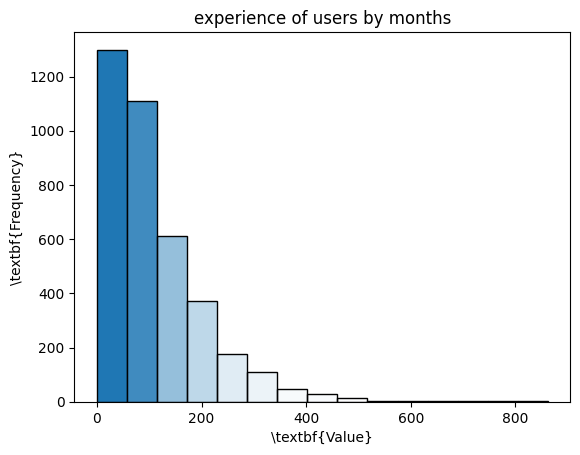

In [ ]:
## histogram to inspect
import seaborn as sns
import matplotlib.pyplot as plt


exp_duration_list = model_df['exp_duration'].tolist()
sorted_exp_duration_list = sorted(exp_duration_list)

n_bins = 15

# Plot histogram with custom color saturation for each bar
sns.histplot(sorted_exp_duration_list, bins=n_bins, kde=False, palette="Blues")

# Get current axes and patches
ax = plt.gca()
patches = ax.patches

# Calculate bin counts
bin_counts, _ = np.histogram(sorted_exp_duration_list, bins=n_bins)

# Update color saturation based on bin counts
for patch, count in zip(patches, bin_counts):
    color = patch.get_facecolor()[:3]  # Extract RGB color tuple
    saturation = min(1, count / max(bin_counts))  # Calculate saturation based on count
    patch.set_facecolor((*color, saturation))

plt.title('experience of users by months')
plt.xlabel(r'\textbf{Value}')
plt.ylabel(r'\textbf{Frequency}')
plt.grid(False)
plt.show()

SMALL = 100
BIG = 250

exp_dict = {}
for num in exp_duration_list:
    if num < SMALL:
        exp_dict[num] = 0
    elif num > BIG:
        exp_dict[num] = 2
    else:
        exp_dict[num] = 1

In [ ]:
### split model_df by the mapping dict from Kmeans or created dict

model_df['exp_group'] = model_df['exp_duration'].map(exp_dict)
model_df['exp_group'].head(10)
print(f"distribution of users by exp:\n{model_df['exp_group'].value_counts()}")
features_df = model_df.drop(columns=['id'])
exp_dfs = []
junior_df = features_df[model_df['exp_group'] == 0].drop(columns = ["exp_group","exp_duration"])
senior_df = features_df[model_df['exp_group'] == 1].drop(columns = ["exp_group","exp_duration"])
expert_df = features_df[model_df['exp_group'] == 2].drop(columns = ["exp_group","exp_duration"])

exp_dfs += [junior_df,senior_df,expert_df]

csv_filename = 'model_df.csv'
model_df.to_csv(csv_filename, index=False)
#files.download('model_df.csv')

distribution of users by exp:
exp_group
0    2167
1    1281
2     328
Name: count, dtype: int64


In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

junior_counts = junior_df["degree_field"].value_counts()
senior_counts = senior_df["degree_field"].value_counts()
expert_counts = expert_df["degree_field"].value_counts()


this is junior
 degree_field
[Computer Science and Engineering]                                                                                                                                                                                                            258
[]                                                                                                                                                                                                                                            248
[Computer Science and Engineering, Computer Science and Engineering]                                                                                                                                                                          119
[Electrical and Computer Engineering]                                                                                                                                                                                                          70
[Me

# Algorithm: k-means clustering

In [ ]:
# Assuming final_df is your DataFrame with columns 'degree_field', 'courses_title', and 'exp_duration'
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

## X_data holds info for pca analysis later
x_data= []
best_silhouette = []
def exp_group_kmeans(model_df):
  # Combine 'degree_field' and 'courses_title' into a single DataFrame
  features_df = model_df[['degree_field', 'courses_title','cert_titles','skills']]

  # Convert lists of strings into a list of lists
  degree_field_lists = features_df['degree_field'].tolist()
  print(len(degree_field_lists))
  courses_title_lists = features_df['courses_title'].tolist()
  skills_lists = features_df['skills'].tolist()
  cert_titles_lists = features_df['cert_titles'].tolist()
  # Create a set of all unique values
  unique_values = set()
  for lst in  degree_field_lists + skills_lists + cert_titles_lists + courses_title_lists  :
    unique_values.update(filter(None, lst))

  print(list(unique_values)[:10])
  # Create a MultiLabelBinarizer and fit it to the unique values
  mlb = MultiLabelBinarizer(classes=sorted(unique_values))
  degree_field_encoded = mlb.fit_transform(degree_field_lists)
  courses_title_encoded = mlb.transform(courses_title_lists)
  skills_encoded = mlb.transform(skills_lists)
  cert_titles_encoded = mlb.transform(cert_titles_lists)

  # Combine one-hot encoded features with exp_duration- these are the columns we input to the model
  X = pd.DataFrame(degree_field_encoded +cert_titles_encoded+courses_title_encoded , columns=mlb.classes_)
  #pca = PCA(n_components=5)
  #X = pca.fit_transform(X)
  silhouette_scores = []
  for n_clusters in range(15, 30, 1):
      #if n_clusters % 10 == 0:
          #print(f"Calculating silhouette score for {n_clusters} clusters")
      kmeans = KMeans(n_clusters=n_clusters, n_init='auto')
      cluster_labels = kmeans.fit_predict(X)
      silhouette_avg = silhouette_score(X, cluster_labels)
      silhouette_scores.append((silhouette_avg,n_clusters))

  # Find the best number of clusters based on silhouette score
  index = np.argmax(silhouette_scores[0])
  best_silhouette.append(silhouette_scores[index])
  best_num_clusters = silhouette_scores[index][1]
  print(f"Best number of clusters based on silhouette score: {best_num_clusters}")
  # Perform clustering using KMeans
  kmeans = KMeans(n_clusters=best_num_clusters, random_state=10,n_init='auto')

  ##data for pca analysis
  clusters = kmeans.fit_predict(X)
  pca = PCA(n_components=2)
  X_pca = pca.fit_transform(X)
  x_data.append((X_pca,clusters))
  model_df['cluster_label'] = kmeans.fit_predict(X)

  # Print the cluster labels
  return model_df[["skills",'degree_field', 'courses_title',"cert_titles", 'cluster_label']],kmeans


In [ ]:
clustered_dfs = []
df_names = ['junior', 'senior', 'expert']
for df,name in zip(exp_dfs,df_names):
  print(f" starting kmeans on: {name}")
  clustered_df , kmeans_model = exp_group_kmeans(df)

# SAVE Kmeans_model for prediction in exp_group
  kmeans_file_name = f"{name}_kmeans.pkl"
  joblib.dump(kmeans_model, kmeans_file_name)
  csv_filename = f"{name}_df.csv"
  clustered_df.to_csv(csv_filename, index=False)
  cluster_counts = clustered_df['cluster_label'].value_counts()

  print(cluster_counts)
  #files.download(csv_filename)


# SAVE CLUSTERED DATASET for predicted cluster analysis
  clustered_dfs.append(clustered_df)

 starting kmeans on: junior
2167
['MCTS', 'Google Analytics Certification', 'electromechanics', 'operating system design', 'Migration', 'Scala', 'Test-Driven', 'Practical Data Science with MATLAB Specialization', 'Intro to Python for Data Science (edX 1.1)', 'Javascript Tutorial Course']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


Best number of clusters based on silhouette score: 16
cluster_label
2     1039
1      500
6      166
3       97
7       83
0       41
14      38
10      38
11      32
9       29
8       27
13      25
4       19
15      15
12      12
5        6
Name: count, dtype: int64
 starting kmeans on: senior
1281
['medical device design', 'translational bioinformatics', 'Professional in Human Resources', 'Prep', 'User Experience Design Essentials - Adobe XD UI UX Design', 'vlsi system design (prof. shahin nazarian)', 'software engineering project', 'Titanium Certified Expert', 'embedded system programming', 'Microsoft Certified Systems Administrator - Server 2003']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


Best number of clusters based on silhouette score: 16
cluster_label
2     569
1     317
4      81
8      73
6      67
0      62
7      37
3      21
9      18
12     12
10      7
5       6
15      5
13      4
11      1
14      1
Name: count, dtype: int64
 starting kmeans on: expert
328
['Architecture', 'Active', 'CPR/AED/First Aid', 'time-series analysis', 'Statistical', 'Strategic Thinking', 'Cognitive and Computational Psychology', 'Advocacy', 'Java Server Pages (JSP 2.1)', 'searching reporting with splunk 6.4']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:895: UserWarning: unknown class(es) [''] will be ignored
  warnings.warn(


Best number of clusters based on silhouette score: 16
cluster_label
0     158
1      54
15     44
7      21
14     15
12     14
10     12
13      2
11      1
4       1
9       1
5       1
6       1
2       1
8       1
3       1
Name: count, dtype: int64


# Evaluating the clusters using silhouette score:


In [ ]:
print(best_silhouette)

[(0.7386049213642915, 16), (0.6887055067084796, 16), (0.6666134957075341, 16)]


# PCA 2d visualization

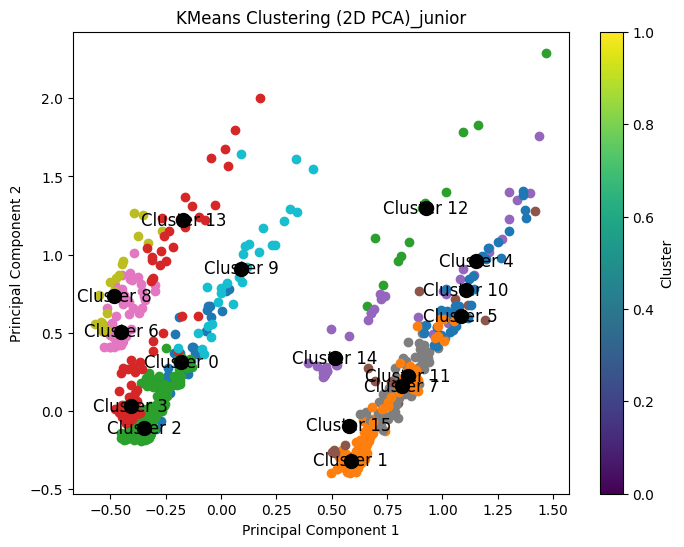

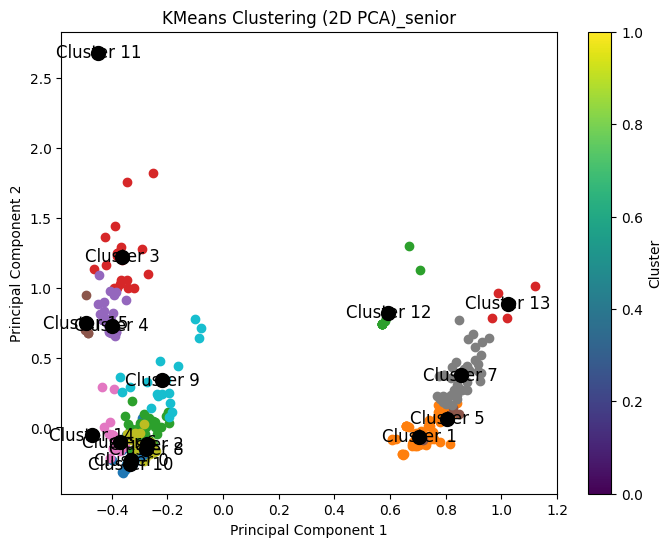

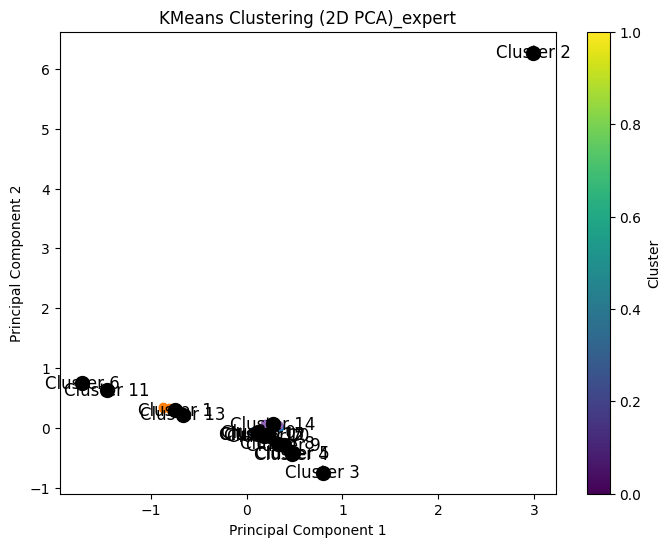

In [ ]:
for i,data in enumerate(x_data):
    plt.figure(figsize=(8, 6))
    for cluster_label in range(len(set(data[1]))):
        cluster_mask = data[1] == cluster_label
        plt.scatter(data[0][cluster_mask, 0], data[0][cluster_mask, 1], label=f'Cluster {cluster_label}')

    # Plot centroids
    centroids = []
    for cluster_label in range(len(set(data[1]))):
        centroid = np.mean(data[0][data[1] == cluster_label], axis=0)
        centroids.append(centroid)
        plt.text(centroid[0], centroid[1], f'Cluster {cluster_label}', color='black', fontsize=12, ha='center', va='center')

    plt.scatter(np.array(centroids)[:, 0], np.array(centroids)[:, 1], marker='o', color='black', s=100)

    plt.title(f'KMeans Clustering (2D PCA)_{df_names[i]}')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.grid(False)
    #plt.legend(title='Clusters', loc='upper right')
    plt.show()

#### Creating a dict of popular skills for every cluster in every experience_group

In [ ]:
#### given the cluster dataset, calculate most common skills, certifications and courses:


#create a dict with key [dataset,cluster,column] and gives a freq sorted list of values
stats_dict = {}
# Iterate over each dataset
for i, dataset in enumerate(clustered_dfs):
    # Split the dataset by the value of the "cluster" column
    clusters = dataset.groupby('cluster_label')

    # Iterate over each cluster
    for cluster, data in clusters:
        # Iterate over each column
        column_values = 0
        for column in data.columns:
            # Skip the "cluster" column itself
            if column == 'cluster_label' or column == 'degree_field':
                continue

            column_values = data[column].tolist()
            flat_values = [item for sublist in column_values for item in sublist]
            # Count the occurrences of each element
            counts = Counter(flat_values)
            # Sort the elements based on their frequency
            sorted_elements = sorted(counts.items(), key=lambda x: x[1], reverse=True)
            sorted_elements = [t[0] for t in sorted_elements]
            # Add the sorted elements to the result dictionary
            key = (df_names[i], cluster, column)
            #print(key)
            stats_dict[key] = sorted_elements

# Print the result dictionary
i=0
for key, value in stats_dict.items():
    print(f"Key: {key}, Value: {value}")
    if i>3:break



In [ ]:
stats_skills_dict = {key: value for key, value in stats_dict.items() if key[2] == 'skills'}
stats_courses_dict = {key: value for key, value in stats_dict.items() if key[2] == 'courses_title'}
stats_cert_dict = {key: value for key, value in stats_dict.items() if key[2] == 'cert_titles'}


popular skills in cluster 1 are: ['Data', 'Web', 'development', 'Java', 'Cloud']
popular skills in cluster 7 are: ['Data', 'Machine', 'Web', 'Programming Paradigms', 'C#']
popular skills in cluster 15 are: ['gRPC', 'development', 'JavaScript', 'techniques', 'Functional']
popular courses in cluster 1 are: ["'", ' ', 'e', 'i', 't']
popular courses in cluster 7 are: [' ', 'e', "'", 'i', 't']
popular courses in cluster 15 are: [' ', "'", 'i', 'n', 'e']
popular certifications in cluster 1 are: ['AWS Certified Cloud Practitioner', 'AWS Certified Solutions Architect – Associate', 'Machine Learning', 'Windows 10: Administration', 'The Data Scientist’s Toolbox']
popular certifications in cluster 7 are: ['APIs and Microservices Certificate', 'Responsive Web Design Developer Certificate', 'Front End Libraries(React) Developer Certificate', 'edX Honor Code Certificate for Information Systems and Computer Applications, Part 1: IT', 'edX Honor Code Certificate for Information Systems and Computer Ap

# wordclouds analysis

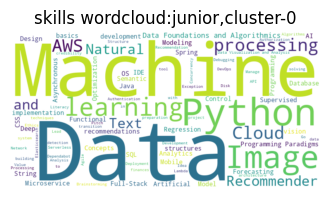

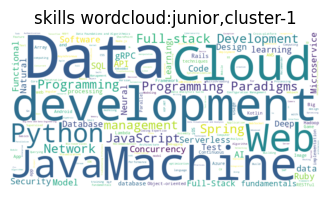

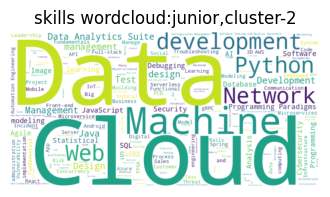

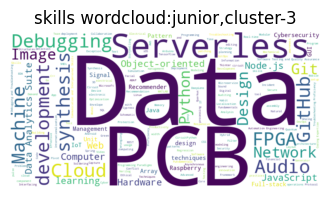

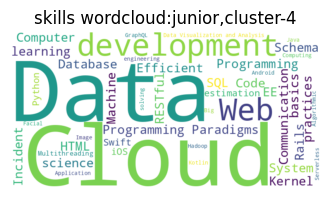

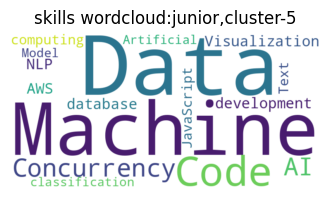

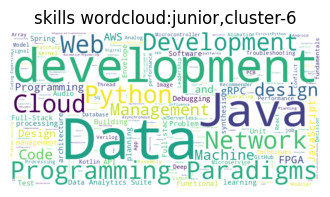

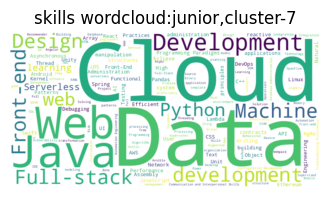

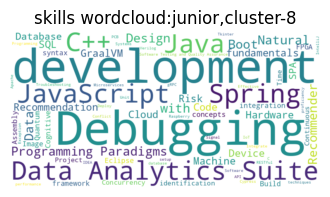

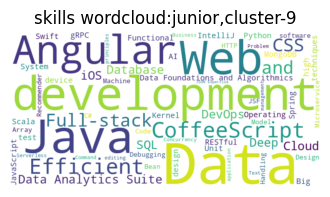

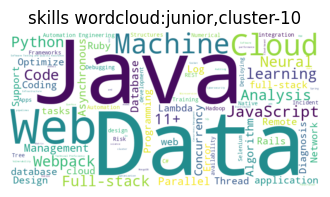

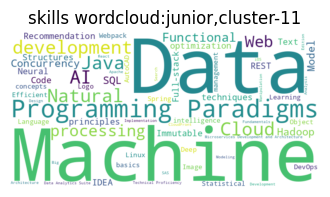

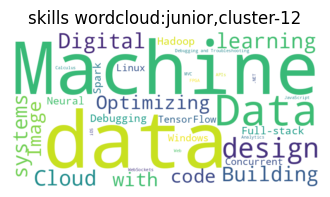

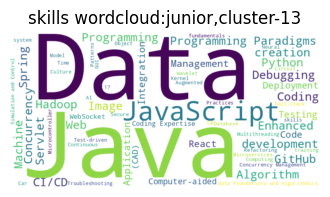

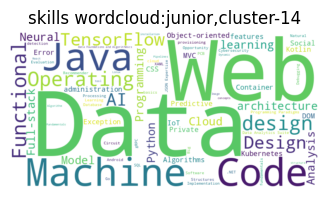

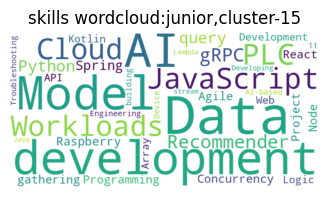

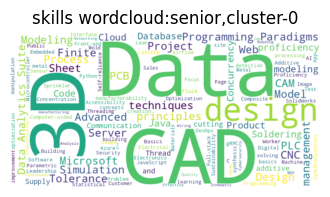

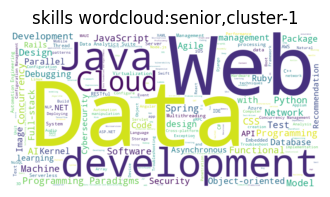

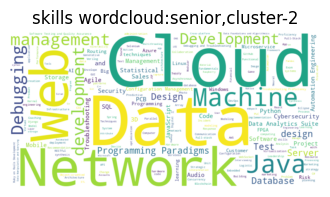

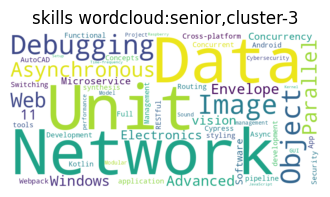

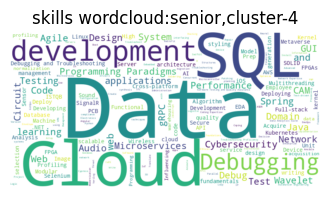

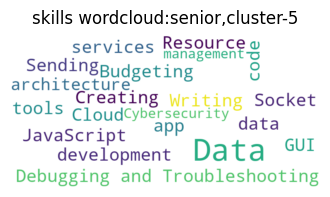

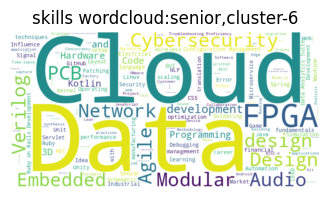

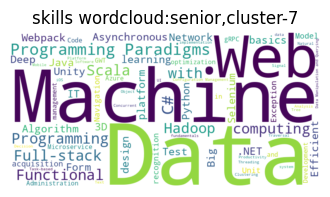

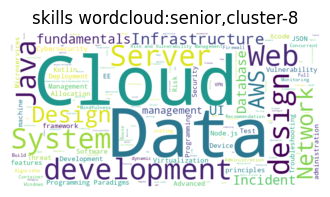

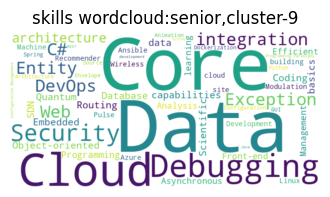

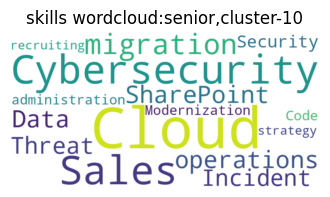

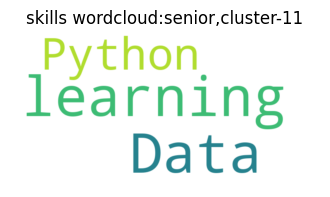

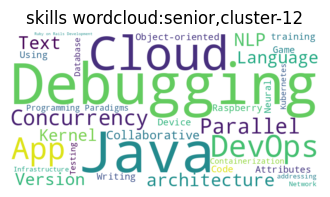

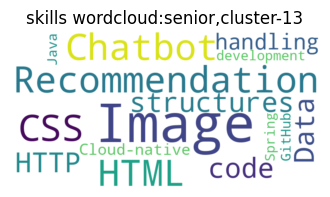

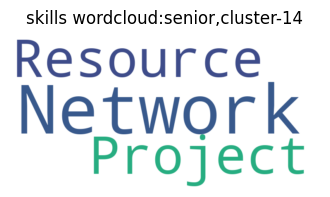

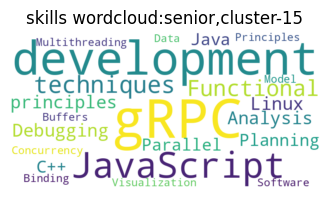

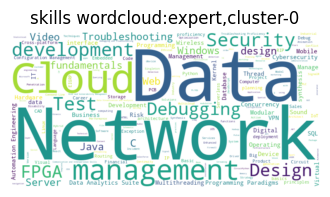

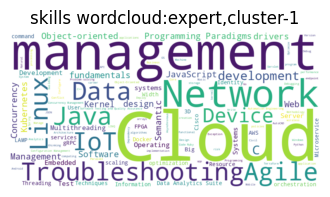

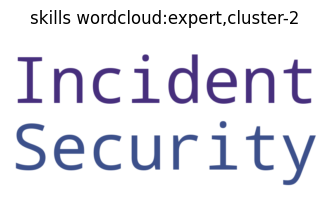

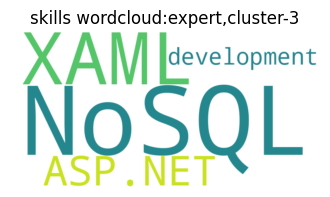

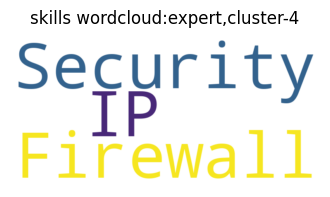

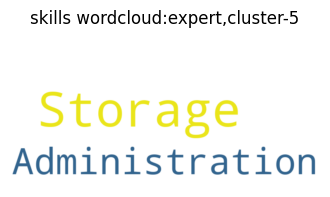

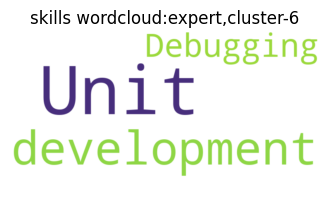

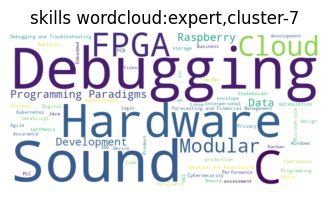

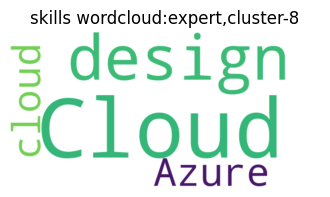

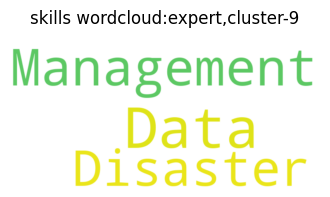

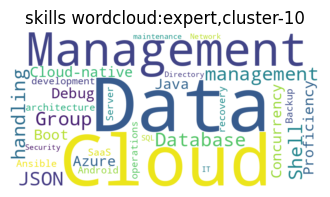

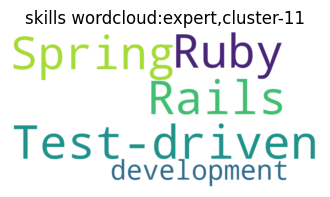

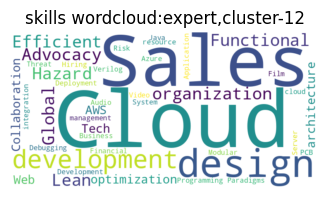

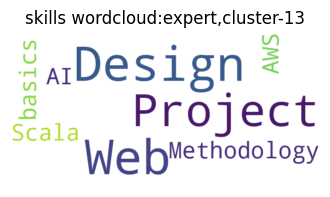

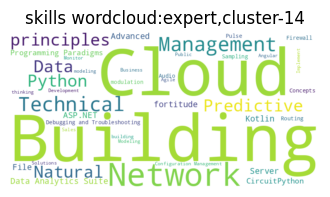

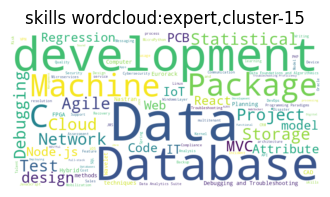

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def calculate_percentage(skill_list):
    total_skills = len(skill_list)
    counts = {}

    # Count occurrences of each skill
    for skill in skill_list:
        if skill not in counts:
            counts[skill] = 0
        counts[skill] += 1

    # Calculate percentage for each skill
    percentages = {}
    for skill, count in counts.items():
        percentages[skill] = (count / total_skills)

    return percentages

# Iterate through each value list in stats_skills_dict
for key, skill_list in stats_skills_dict.items():
    # Calculate percentages for the current skill list
    percentages = calculate_percentage(skill_list)

    # Sort percentages by value in descending order
    sorted_percentages = sorted(percentages.items(), key=lambda x: x[1], reverse=True)

    # Create word frequency dictionary
    elements = [item[0] for item in sorted_percentages]
    percentages = [item[1] for item in sorted_percentages]
    word_freq = {element: percentage for element, percentage in zip(elements, percentages)}

    # Generate word cloud for the current skill list
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    # Plot word cloud
    plt.figure(figsize=(4, 4))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'skills wordcloud:{key[0]},cluster-{key[1]}')
    plt.show()


In [ ]:
from wordcloud import WordCloud

def calculate_percentage(dict_values):
    total_lists = len(dict_values)
    counts = {}

    # Count occurrences of each element in the first 5 indexes
    for lst in dict_values.values():
        for index, element in enumerate(lst[:5]):
            if element not in counts:
                counts[element] = 0
            counts[element] += 1

    # Calculate percentage for each element
    percentages = {}
    for element, count in counts.items():
        percentages[element] = (count / total_lists)

    return percentages

# Calculate percentages
percentages = calculate_percentage(stats_skills_dict)

# Sort percentages by value in descending order
sorted_percentages = sorted(percentages.items(), key=lambda x: x[1], reverse=True)

elements = [item[0] for item in sorted_percentages]
percentages = [item[1] for item in sorted_percentages]




In [ ]:
from wordcloud import WordCloud

def calculate_percentage(dict_values):
    total_lists = len(dict_values)
    counts = {}

    # Count occurrences of each element in the first 5 indexes
    for lst in dict_values.values():
        for index, element in enumerate(lst[:5]):
            if element not in counts:
                counts[element] = 0
            counts[element] += 1

    # Calculate percentage for each element
    percentages = {}
    for element, count in counts.items():
        percentages[element] = (count / total_lists)

    return percentages

# Calculate percentages
percentages = calculate_percentage(stats_skills_dict)

# Sort percentages by value in descending order
sorted_percentages = sorted(percentages.items(), key=lambda x: x[1], reverse=True)

elements = [item[0] for item in sorted_percentages]
percentages = [item[1] for item in sorted_percentages]

word_freq = {element: percentage for element, percentage in zip(elements, percentages)}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of apearence of skills in clusters')
plt.show()

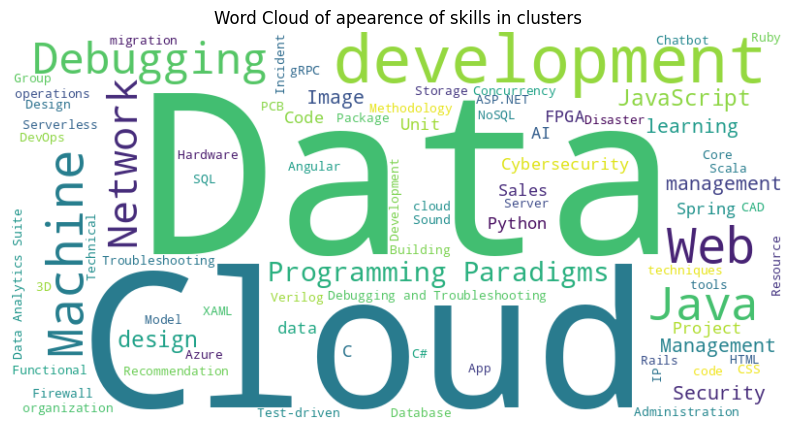

In [ ]:
word_freq = {element: percentage for element, percentage in zip(elements, percentages)}

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# Plot word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of apearence of skills in clusters')
plt.show()

# Evaluation Metrics:

**Metric 1:** Percentage of "sucessful" clusterings for each category and for each cluster.
Definitions:

1. A user is sucessfully clustered if at least one of his skills appears in the 5 most frequent skills in the cluster he belongs to.

2. A cluster is defined as a "best cluster" if more than 50% of users were successfully clustered.

In [ ]:
from collections import Counter

def skills_freq(user_skills, cluster_df):
    # Count the frequency of all skills in the cluster
    all_skills = [skill for skills in cluster_df['skills'] for skill in skills]
    counts = Counter(all_skills)

    # Subtract 1 from the count if the skill belongs to the user
    for skill in user_skills:
        if skill in counts:
            counts[skill] -= 1

    # Get the top 5 most frequent skills
    top_skills = [skill for skill, _ in counts.most_common(5)]

    # Check if at least one user skill appears in the top 5
    if any(skill in user_skills for skill in top_skills):
        return 1
    else:
        return 0

count_cluster_cats = {'junior': [], 'senior': [], 'expert': []}
count_datasets = {'junior': 0, 'senior': 0, 'expert': 0}

# Example usage
for i, dataset in enumerate(clustered_dfs):
    for _, cluster_df in dataset.groupby('cluster_label'):
        count_cluster = 0
        cluster_length = len(cluster_df)

        for _, user_row in cluster_df.iterrows():
            user_skills = user_row['skills']
            result = skills_freq(user_skills, cluster_df)
            count_cluster += result
            count_datasets[df_names[i]] += result

        # Calculate the percentage of users in the cluster with at least one skill in the top 5
        percentage = (count_cluster / cluster_length) * 100
        count_cluster_cats[df_names[i]].append(round(percentage, 2))
    count_datasets[df_names[i]]/=len(dataset)
    count_datasets[df_names[i]]*=100

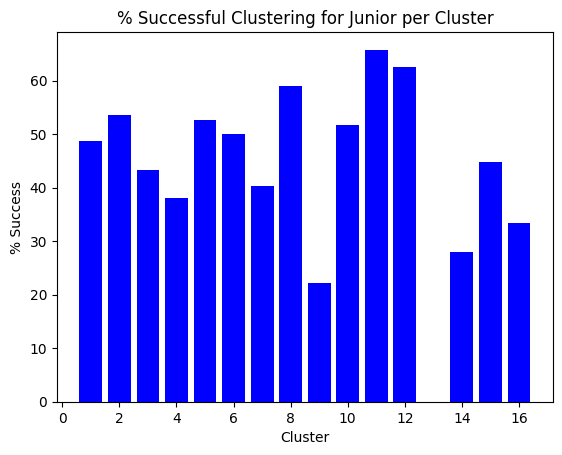

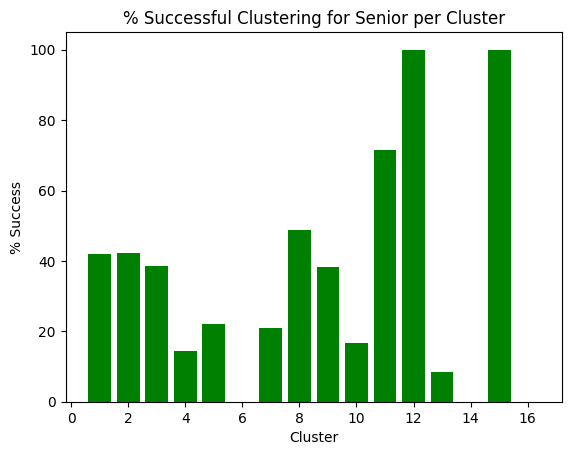

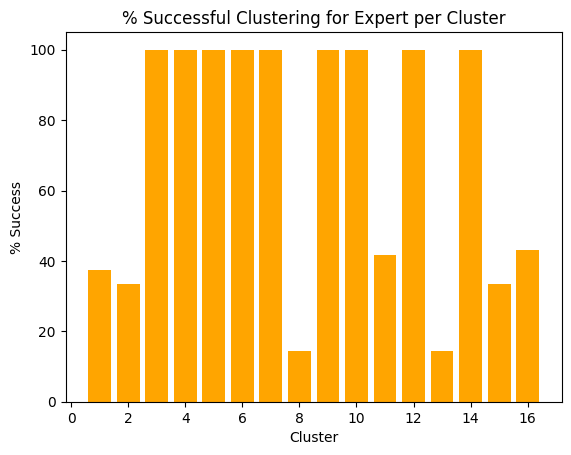

In [ ]:

# Function to create bar plots
def create_bar_plot(category, values,color):
    num_clusters = len(values)
    cluster_indices = range(1, num_clusters + 1)

     # Create bar plot with specified color
    plt.bar(cluster_indices, values, color=color)

    # Add title and labels
    plt.title(f"% Successful Clustering for {category} per Cluster")
    plt.xlabel("Cluster")
    plt.ylabel("% Success")

    # Show plot
    plt.show()

# Create bar plots for each category with specified colors
create_bar_plot("Junior", count_cluster_cats['junior'], 'blue')
create_bar_plot("Senior", count_cluster_cats['senior'], 'green')
create_bar_plot("Expert", count_cluster_cats['expert'], 'orange')


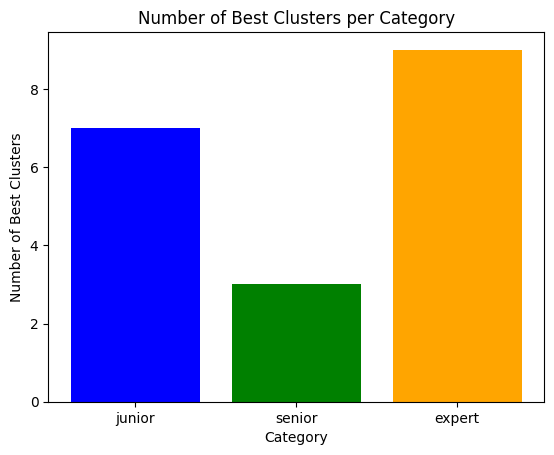

In [ ]:
# Define colors
colors = {'junior': 'blue', 'senior': 'green', 'expert': 'orange'}
# Count the number of values that are 50 and above for each category
counts = {category: sum(value >= 50 for value in values) for category, values in count_cluster_cats.items()}

# Extract categories and counts
categories = list(counts.keys())
count_values = list(counts.values())

# Create bar plot
plt.bar(categories, count_values, color=[colors[category] for category in categories])

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Number of Best Clusters')
plt.title('Number of Best Clusters per Category')

# Show plot
plt.show()

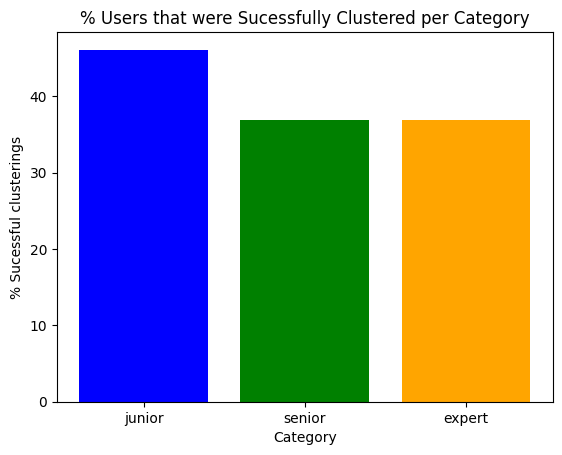

In [ ]:
# Extract keys and values from the dictionary
categories = list(count_datasets.keys())
lengths = list(count_datasets.values())

# Define custom colors
custom_colors = ['blue', 'green', 'orange']

# Create histogram using bar plot with custom colors
plt.bar(categories, lengths, color=custom_colors)

# Add title and labels
plt.title('% Users that were Sucessfully Clustered per Category')
plt.xlabel('Category')
plt.ylabel('% Sucessful clusterings')

# Show plot
plt.show()

**Metric 2:** uniqueness of cluster skill recommendation in matching experience groups.

for every group, we will take the most frequent k skills as a set, and analyze how many sets of skills are unique, indicating how unique are clusters, and how significant is for a user to be classified into one cluster and not the other.

clarification: if a cluster has less skills than k, we will check if the cluster skills are contained in other clusters, making it more likely the cluster is not "unique"

In [ ]:
### split the skills dict to experience_based_dicts

junior_dict_skills = {}
senior_dict_skills = {}
expert_dict_skills = {}


for key, value in stats_skills_dict.items():
    category, _, _ = key

    if category == "junior":
        junior_dict_skills[key] = value
    elif category == "senior":
        senior_dict_skills[key] = value
    elif category == "expert":
        expert_dict_skills[key] = value

for key, value_list in junior_dict_skills.items():
    # Convert each string in the value list to lowercase
    lowercase_value_list = [item.lower() for item in value_list]
    # Update the dictionary with the new lowercase value list
    junior_dict_skills[key] = lowercase_value_list

for key, value_list in senior_dict_skills.items():
    # Convert each string in the value list to lowercase
    lowercase_value_list = [item.lower() for item in value_list]
    # Update the dictionary with the new lowercase value list
    senior_dict_skills[key] = lowercase_value_list

for key, value_list in expert_dict_skills.items():
    # Convert each string in the value list to lowercase
    lowercase_value_list = [item.lower() for item in value_list]
    # Update the dictionary with the new lowercase value list
    expert_dict_skills[key] = lowercase_value_list

print(len(junior_dict_skills))
print(len(senior_dict_skills))
print(len(expert_dict_skills))

16
16
16


In [ ]:
def truncate_and_fill(lst,k):
    truncated_list = lst[:k]  # Take the first k unique elements
    truncated_list = sorted(truncated_list)
    return truncated_list

# Function to process a dictionary and modify its values
def process_dict(input_dict,k):
    output_dict = {}
    for key, value_list in input_dict.items():
        truncated_list = truncate_and_fill(value_list,k)
        output_dict[key] = truncated_list
    return output_dict


## measure how many unique clusters for every dict
def count_unique_lists(dictionary):
  unique_lists = []  # To store unique list representations
  unique_count = 0

  for key, value in dictionary.items():
    ulist_set = set('d')
    values_set = set('m')
    # Check if the current list is unique by comparing with existing unique lists
    is_unique = True
    for ulist in unique_lists:
      ulist_set = set(ulist)
      values_set = set(value)
      if (values_set.issubset(ulist_set)) or (ulist_set.issubset(values_set)):
          is_unique = False
          break

    if is_unique:
        unique_lists.append(value)
        unique_count += 1
    #print(unique_lists)
  return unique_count

In [ ]:
## create k_sized sets of popular skills for every cluster
junior_uniqueness = []
senior_uniqueness = []
expert_uniqueness = []

for k in range(1,9):
  junior_dict_processed = process_dict(junior_dict_skills,k)
  senior_dict_processed = process_dict(senior_dict_skills,k)
  expert_dict_processed = process_dict(expert_dict_skills,k)

  for key, value in senior_dict_processed.items():
    print(key, ':', value)


  # Count unique sets in each dictionary
  junior_uniqueness.append(count_unique_lists(junior_dict_processed))
  senior_uniqueness.append(count_unique_lists(senior_dict_processed))
  expert_uniqueness.append(count_unique_lists(expert_dict_processed))



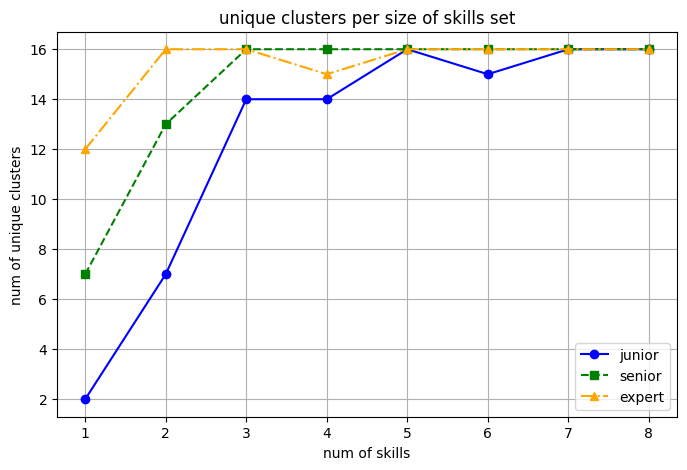

In [ ]:
x_values = range(len(junior_uniqueness))  # Use indices as x-values
x_values = [1+x for x in x_values]
# Plotting all three lists on the same plot
plt.figure(figsize=(8, 5))  # Adjust figure size if needed
plt.plot(x_values, junior_uniqueness, label='junior', color='blue', linestyle='-', marker='o')
plt.plot(x_values, senior_uniqueness, label='senior', color='green', linestyle='--', marker='s')
plt.plot(x_values, expert_uniqueness, label='expert', color='orange', linestyle='-.', marker='^')

# Add labels and title
plt.xlabel('num of skills')
plt.ylabel('num of unique clusters')
plt.title('unique clusters per size of skills set')
plt.legend()  # Show legend with labels

# Show plot
plt.grid(True)  # Add grid for better readability
plt.show()